### Download the dataset from kaggle

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/blood-cells")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/blood-cells


### Necessary Libraries

In [2]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Here we do classification part so we work on dataset2-master  folder

In [3]:
data_dir = '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images'

# List the contents of the images directory
print(os.listdir(data_dir))


['TEST_SIMPLE', 'TEST', 'TRAIN']


*****checking the folders in train*****

In [4]:
import os

data_dir = '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN'

# List the contents of the images directory
print(os.listdir(data_dir))


['MONOCYTE', 'NEUTROPHIL', 'LYMPHOCYTE', 'EOSINOPHIL']


**show the first few 5 datapaths and its labels**

In [5]:


# Set the path to the images folder
data_dir = '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN'

# Define the class labels (folder names)
class_labels = ['MONOCYTE', 'NEUTROPHIL', 'LYMPHOCYTE', 'EOSINOPHIL']

# Initialize lists to hold file paths and labels
filepaths = []
labels = []

# Loop through each class folder and collect image file paths and labels
for label in class_labels:
    class_dir = os.path.join(data_dir, label)
    for file in os.listdir(class_dir):
        if file.endswith(('.jpg', '.jpeg', '.png')):  # Ensure only image files are included
            filepaths.append(os.path.join(class_dir, file))
            labels.append(label)

# Create a DataFrame
bloodcell_df = pd.DataFrame({
    'filepath': filepaths,
    'label': labels
})

# Shuffle the dataset
bloodcell_df = bloodcell_df.sample(frac=1).reset_index(drop=True)

# Show the first few rows
bloodcell_df.head()


,filepath,label
0,/kaggle/input/blood-cells/dataset2-master/data...,LYMPHOCYTE
1,/kaggle/input/blood-cells/dataset2-master/data...,MONOCYTE
2,/kaggle/input/blood-cells/dataset2-master/data...,LYMPHOCYTE
3,/kaggle/input/blood-cells/dataset2-master/data...,EOSINOPHIL
4,/kaggle/input/blood-cells/dataset2-master/data...,EOSINOPHIL


**Random picture for visualization**

In [6]:
import matplotlib.pyplot as plt
import cv2

def show_images(df, num_images=25):
    plt.figure(figsize=(15, 15))

    # Pick random samples
    sample_df = df.sample(n=num_images).reset_index(drop=True)

    for i in range(num_images):
        filepath = sample_df.loc[i, 'filepath']
        label = sample_df.loc[i, 'label']

        # Read the image using OpenCV and convert BGR to RGB
        img = cv2.imread(filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(5, 5, i + 1)
        plt.imshow(img)
        plt.title(label, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


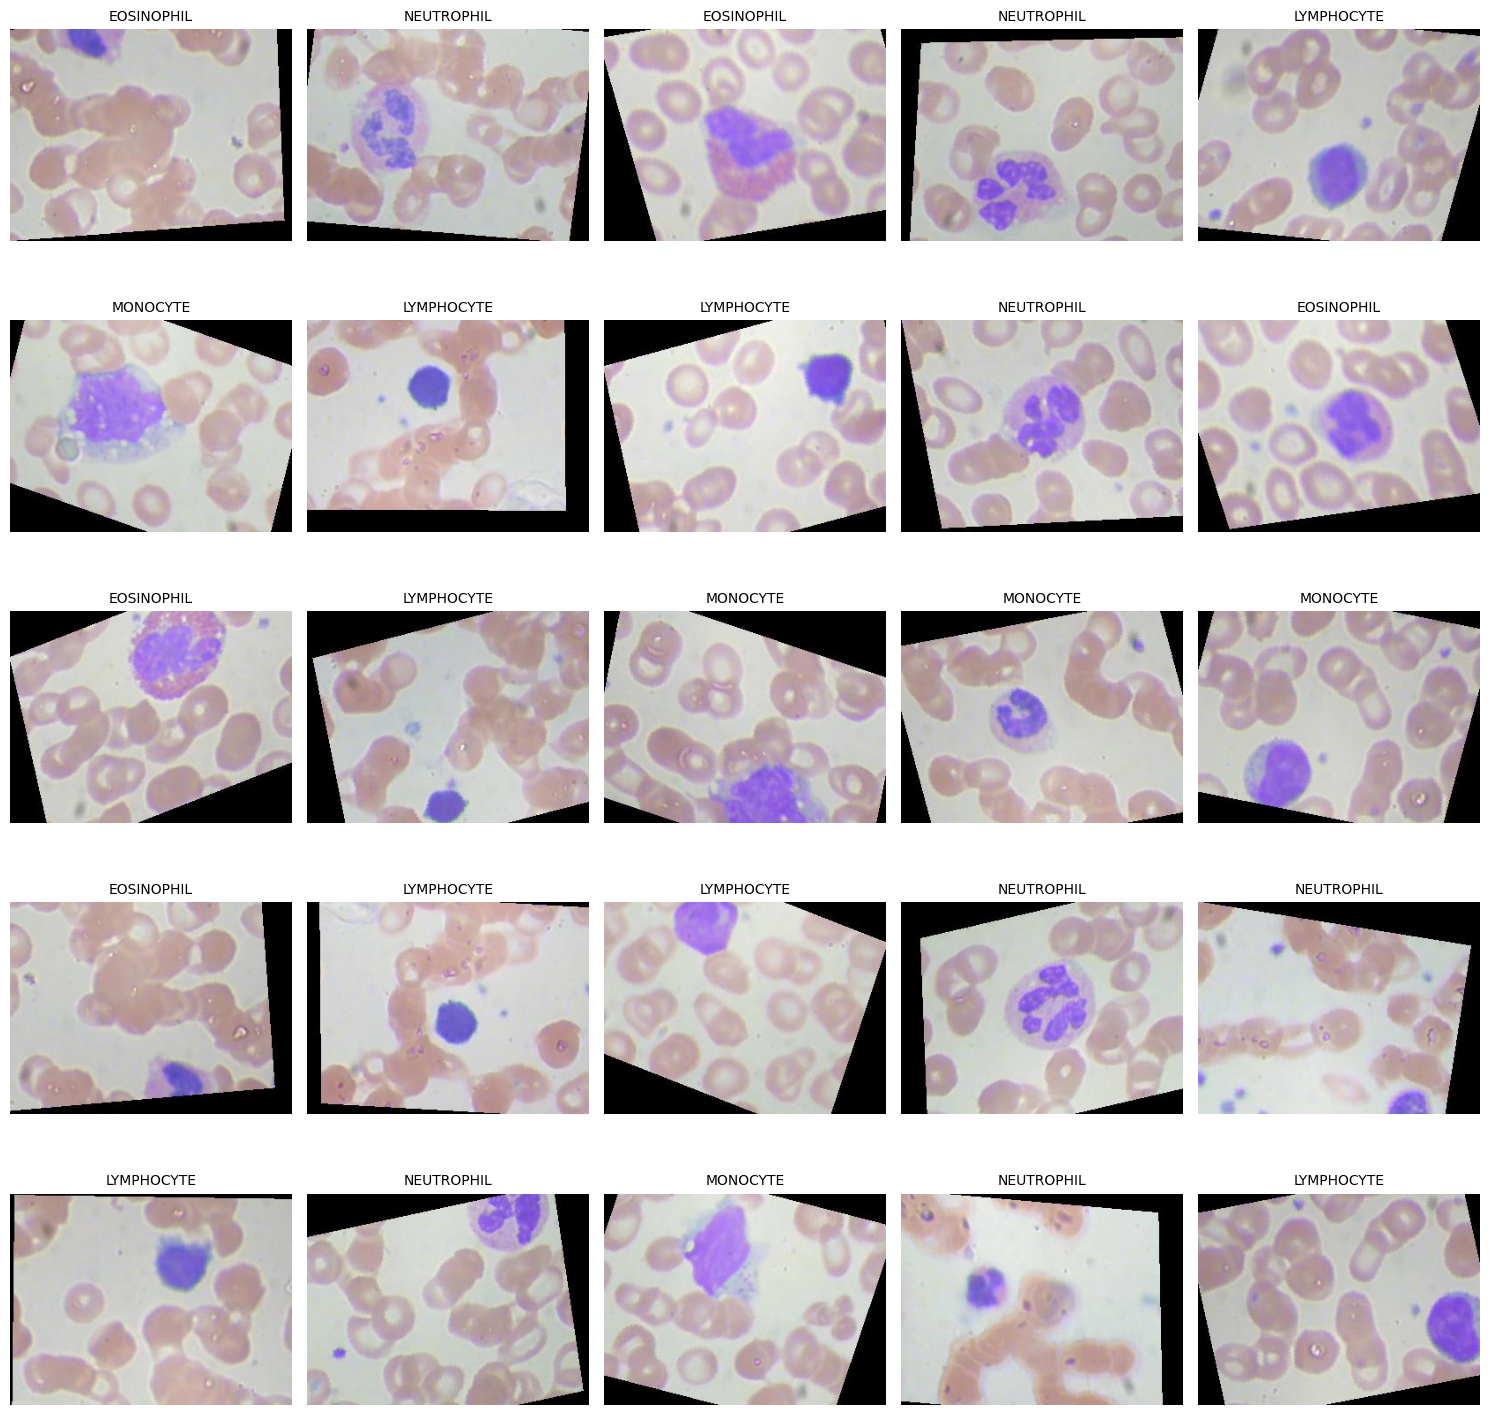

In [7]:
show_images(bloodcell_df)


In [8]:
data_dir = '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images'

train_dir = os.path.join(data_dir, 'TRAIN')
val_dir   = os.path.join(data_dir, 'TEST_SIMPLE')   # or use TRAIN with validation_split
test_dir  = os.path.join(data_dir, 'TEST')


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 9957 images belonging to 4 classes.
Found 71 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


### Model Train

In [12]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("Blood Cell.h5", monitor='val_accuracy', save_best_only=True)

In [14]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, model_checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.7520 - loss: 0.5759

312/312 ━━━━━━━━━━━━━━━━━━━━ 266s 655ms/step - accuracy: 0.7525 - loss: 0.5750 - val_accuracy: 0.1831 - val_loss: 1.4383
Epoch 2/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.9709 - loss: 0.0823

312/312 ━━━━━━━━━━━━━━━━━━━━ 152s 485ms/step - accuracy: 0.9709 - loss: 0.0823 - val_accuracy: 0.2817 - val_loss: 1.5089
Epoch 3/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.9861 - loss: 0.0400

312/312 ━━━━━━━━━━━━━━━━━━━━ 203s 487ms/step - accuracy: 0.9861 - loss: 0.0401 - val_accuracy: 0.8592 - val_loss: 1.1217
Epoch 4/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 146s 466ms/step - accuracy: 0.9913 - loss: 0.0297 - val_accuracy: 0.6056 - val_loss: 2.7887
Epoch 5/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.9854 - loss: 0.0442

312/312 ━━━━━━━━━━━━━━━━━━━━ 153s 491ms/step - accuracy: 0.9854 - loss: 0.0442 - val_accuracy: 0.9155 - val_loss: 0.5886
Epoch 6/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 145s 466ms/step - accuracy: 0.9867 - loss: 0.0410 - val_accuracy: 0.9155 - val_loss: 0.7536
Epoch 7/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 145s 464ms/step - accuracy: 0.9963 - loss: 0.0103 - val_accuracy: 0.4930 - val_loss: 3.7399
Epoch 8/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 203s 467ms/step - accuracy: 0.9900 - loss: 0.0346 - val_accuracy: 0.8592 - val_loss: 0.9676
Epoch 9/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 202s 465ms/step - accuracy: 0.9930 - loss: 0.0239 - val_accuracy: 0.8451 - val_loss: 1.0278
Epoch 10/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.9971 - loss: 0.0103

312/312 ━━━━━━━━━━━━━━━━━━━━ 209s 488ms/step - accuracy: 0.9971 - loss: 0.0103 - val_accuracy: 0.9437 - val_loss: 0.2175
Epoch 11/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 145s 465ms/step - accuracy: 0.9912 - loss: 0.0233 - val_accuracy: 0.8592 - val_loss: 0.8654
Epoch 12/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 202s 465ms/step - accuracy: 0.9959 - loss: 0.0125 - val_accuracy: 0.8592 - val_loss: 2.1562
Epoch 13/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 144s 463ms/step - accuracy: 0.9924 - loss: 0.0297 - val_accuracy: 0.8169 - val_loss: 1.3194
Epoch 14/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 144s 462ms/step - accuracy: 0.9847 - loss: 0.0483 - val_accuracy: 0.8592 - val_loss: 1.3795
Epoch 15/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 145s 466ms/step - accuracy: 0.9954 - loss: 0.0139 - val_accuracy: 0.9296 - val_loss: 0.7459


### Model saving and test accuracy


In [15]:
model.load_weights("Blood Cell.h5")
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

78/78 ━━━━━━━━━━━━━━━━━━━━ 17s 219ms/step - accuracy: 0.9181 - loss: 0.3108
Test Loss: 0.4381, Test Accuracy: 90.59%


### Confusion matrix


78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step


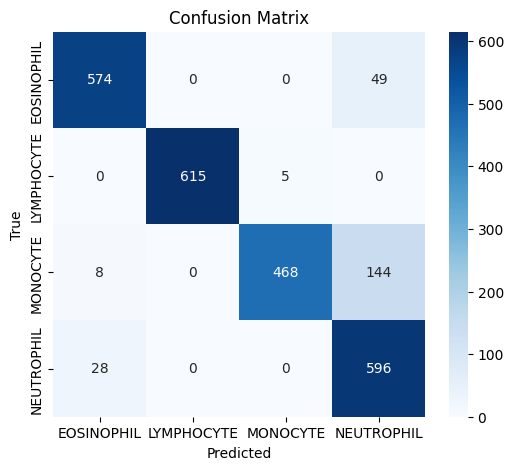

              precision    recall  f1-score   support

  EOSINOPHIL       0.94      0.92      0.93       623
  LYMPHOCYTE       1.00      0.99      1.00       620
    MONOCYTE       0.99      0.75      0.86       620
  NEUTROPHIL       0.76      0.96      0.84       624

    accuracy                           0.91      2487
   macro avg       0.92      0.91      0.91      2487
weighted avg       0.92      0.91      0.91      2487



In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)
labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=labels))

### Based on history of epochs tarin and validation curves

In [21]:
import matplotlib.pyplot as plt

# Training data from your log
accuracy = [0.7520, 0.9709, 0.9861, 0.9913, 0.9854, 0.9867, 0.9963, 0.9900, 0.9930, 0.9971, 0.9912, 0.9959, 0.9924, 0.9847, 0.9954]
val_accuracy = [0.1831, 0.2817, 0.8592, 0.6056, 0.9155, 0.9155, 0.4930, 0.8592, 0.8451, 0.9437, 0.8592, 0.8592, 0.8169, 0.8592, 0.9296]

loss = [0.5759, 0.0823, 0.0400, 0.0297, 0.0442, 0.0410, 0.0103, 0.0346, 0.0239, 0.0103, 0.0233, 0.0125, 0.0297, 0.0483, 0.0139]
val_loss = [1.4383, 1.5089, 1.1217, 2.7887, 0.5886, 0.7536, 3.7399, 0.9676, 1.0278, 0.2175, 0.8654, 2.1562, 1.3194, 1.3795, 0.7459]

epochs = range(1, len(accuracy) + 1)


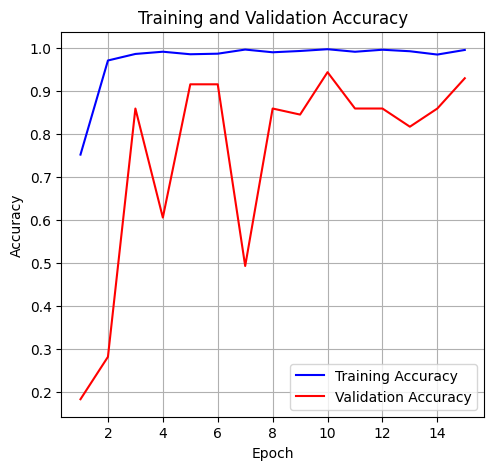

In [24]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


### For train and validation loss curves

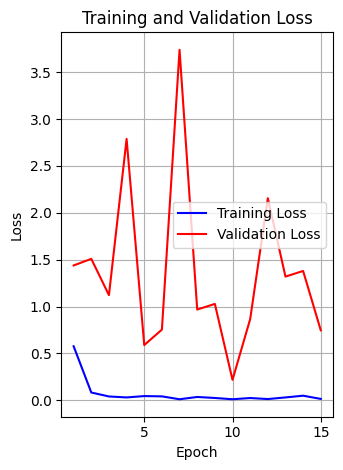

In [25]:

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
